### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict
np.seterr(divide = 'ignore') 
np.seterr(invalid = 'ignore') 
from multiprocessing.dummy import Pool as ThreadPool
import time
import matplotlib.pyplot as plt


In [7]:
np.seterr(divide = 'ignore') 
np.seterr(invalid = 'ignore') 
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        if criterion == 'gini': 
            self.Qf = self.__gini
        if criterion == 'misclass': 
            self.Qf = self.__misclass
        if criterion == 'entropy': 
            self.Qf = self.__entropy
        # Для последнего задания
        self.feature_importances_ = defaultdict(int)
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        self.uses_features = set()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def Fe(self,y):
        return 1 - np.max(np.bincount(y)/y.shape[0])
    
    def __misclass(self,y, y_l, y_r):
        return self.Fe(y) - y_l.shape[0]/(y_l.shape[0] + y_r.shape[0])*self.Fe(y_l)- y_r.shape[0]/(y_l.shape[0]+y_r.shape[0])*self.Fe(y_r)
    
    def Fg(self,y):
        return 1 - np.sum((np.bincount(y) / y.shape[0]) ** 2)
    
    def __gini(self,y, y_l, y_r):
        return self.Fg(y) - y_l.shape[0]/(y_l.shape[0] + y_r.shape[0])*self.Fg(y_l)- y_r.shape[0]/(y_l.shape[0]+y_r.shape[0])*self.Fg(y_r)
        
    def Fh(self,y):
        return - np.sum((np.bincount(y) / y.shape[0]) * (np.log(np.bincount(y) / y.shape[0])))

    def __entropy(self, y, y_l, y_r):
        return self.Fh(y) - y_l.shape[0]/(y_l.shape[0] + y_r.shape[0])*self.Fh(y_l)- y_r.shape[0]/(y_l.shape[0]+y_r.shape[0])*self.Fh(y_r)
    
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        # Ваш код здесь
        thresholds = np.zeros(x.shape)
        Qs = np.zeros(x.shape)
        for feature_idx in range(x.shape[1]):
            if feature_idx in self.uses_features:
                continue
            for idx in range(x[:,feature_idx].shape[0]):
                threshold = x[:,feature_idx][idx] 
                x_l, x_r, y_l, y_r = self.__div_samples(x,y, feature_idx, threshold)
                if(y_l.shape[0] == 0 or y_r.shape[0] == 0):
                    continue
                Q = self.Qf(y, y_l, y_r)
                thresholds[idx,feature_idx] =  threshold
                Qs[idx,feature_idx] =  Q
        max_ = Qs.argmax()
        return np.unravel_index(max_, thresholds.shape)    

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        classes_count = np.bincount(y)
        # Ваш код здесь
        if (self.max_depth is not None and depth >= self.max_depth 
                            or np.max(classes_count) == y.shape[0] 
                            or y.shape[0] < self.min_samples_split):
            self.tree[node_id] = (1, classes_count.argmax())
            #self.tree[node_id] = (LEAF_TYPE, classes_count.argmax())
            return
        idx, feature_idx = self.__find_threshold(x,y) 
        threshold = x[idx, feature_idx]
        if threshold is None:
            self.tree[node_id] = (self.LEAF_TYPE, classes_count.argmax())
            return
        self.uses_features.add(feature_idx)
        
        x_l, x_r, y_l, y_r = self.__div_samples(x, y, feature_idx, threshold)
        
        if x_l.shape[0] == 0 or x_r.shape[0] == 0:
            self.tree[node_id] = (self.LEAF_TYPE, classes_count.argmax())
            return
        
        self.tree[node_id] = (self.NON_LEAF_TYPE, feature_idx, threshold)
        self.feature_importances_[feature_idx] += self.Qf(y, y_l, y_r)
        self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)
        

    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

In [8]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='misclass')
clf = DecisionTreeClassifier(min_samples_split=2)

In [9]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [10]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [65]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.9444444444444444


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [37]:
%time clf.fit(X_train, y_train)
%time clf.fit(X_train, y_train)
%time clf.fit(X_train, y_train)

CPU times: user 2.09 ms, sys: 552 µs, total: 2.65 ms
Wall time: 1.68 ms
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.76 ms
CPU times: user 1.62 ms, sys: 26 µs, total: 1.64 ms
Wall time: 1.46 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [39]:
%time my_clf.fit(X_train, y_train)
%time my_clf.fit(X_train, y_train)
%time my_clf.fit(X_train, y_train)

CPU times: user 2.91 ms, sys: 500 µs, total: 3.41 ms
Wall time: 2.18 ms
CPU times: user 1.7 ms, sys: 0 ns, total: 1.7 ms
Wall time: 1.43 ms
CPU times: user 1.24 ms, sys: 108 µs, total: 1.34 ms
Wall time: 1.22 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [16]:
df = pd.read_csv('Speed Dating Data.csv', encoding='cp1251')
df = df.iloc[:, :97]

In [17]:
df = df.drop(['id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner', 'age_o', 'race_o','pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun','pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o',   'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o','prob_o','met_o', 'field', 'undergra', 'from','zipcode', 'career', 'sports', 'tvsports','exercise', 'dining', 'museums', 'art', 'hiking','gaming', 'clubbing', 'reading', 'tv', 'theater','movies', 'concerts', 'music', 'shopping', 'yoga','expnum', 'wave'], axis=1)
df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(0)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'mn_sat'] = df.mn_sat.fillna(-999)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.loc[:, 'tuition'] = df.tuition.fillna(-999)
df = df.dropna(subset=['imprelig', 'imprace'])
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)
df = df.dropna(subset=['date'])
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(0)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1','intel1_1', 'fun1_1',
                                                    'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1','amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1','intel2_1', 'fun2_1',
                                        'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1','amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
            'intel{}_1'.format(i), 'fun{}_1'.format(i),
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    if i != 4:
        feat.remove('shar{}_1'.format(i))

df = df.drop(feat, axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid']).drop(['gender'], axis=1).dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid']).drop(['gender', 'match',
                          'int_corr', 'samerace'], axis=1).dropna()
df_female.columns = df_female.columns + '_f'
df_female = df_female.drop(['pid_f'], axis=1)
df_pair = df_male.join(df_female.set_index('iid_f'), on='pid', how='inner')
df_pair = df_pair.drop(['iid', 'pid'], axis=1)

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [18]:
X = df_pair.iloc[:, 1:].values
y = df_pair.iloc[:, 0].values 

In [19]:
folds = StratifiedKFold(n_splits=3)

In [20]:
def get_scores(arg):
    np.seterr(divide = 'ignore') 
    np.seterr(invalid = 'ignore') 
    criterion_a, depth_a, min_samples_split_a = arg
    score =  0
    for train, test in folds.split(X, y):
        my_clf = MyDecisionTreeClassifier(min_samples_split=min_samples_split_a, 
                                      max_depth = depth_a, criterion = criterion_a)
        my_clf.fit(X[train], y[train])
        pred = my_clf.predict(X[test])
        score += accuracy_score(pred, y[test]) 
    return (score/3., criterion_a, depth_a,  min_samples_split_a)

In [21]:
args = []
for criterion in ['entropy', 'gini', 'misclass']:
    for depth in range(10, 23):
        for min_samples_split in range(2,9):
            args.append((criterion, depth,  min_samples_split))

In [ ]:
scores =[]
with ThreadPool(8) as pool:
    scores3 = list(pool.map(get_scores, args))
pool.join()

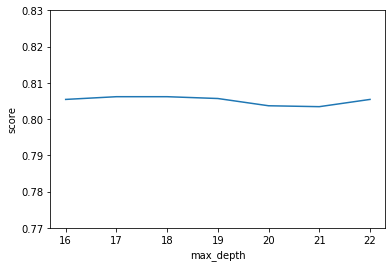

In [129]:
depth_x = [i[2] for i in scores if i[1]=='entropy' and i[3] ==8]
scores_y = [i[0] for i in scores if i[1]=='entropy'and i[3] ==8]
depth_x, scores_y = zip(*sorted(zip(depth_x, scores_y)))
plt.ylim(0.77,0.83)
plt.xlabel('max_depth')
plt.ylabel('score')
plt.plot(depth_x,scores_y)

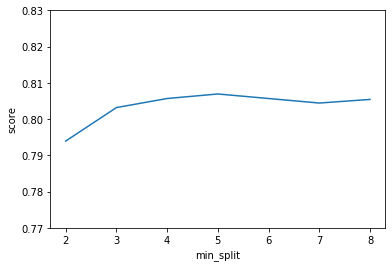

In [130]:
min_split_x = [i[3] for i in tmp if i[1]=='entropy' and i[2] ==16]
scores_y = [i[0]    for i in tmp if i[1]=='entropy'and i[2] ==16]
min_split_x, scores_y = zip(*sorted(zip(min_split_x, scores_y)))

plt.ylim(0.77,0.83)
plt.xlabel('min_split')
plt.ylabel('score')
plt.plot(min_split_x,scores_y)

Каких то определенных зависимостей здесь наблюдать не удается ни при каких комбинациях параметров

In [13]:
scores =[(0.8144536134033508, 'gini', 16, 4)]

In [14]:
best_score, best_criterion, best_depth, best_min_split = max(scores)
print(max(scores))

(0.8144536134033508, 'gini', 16, 4)


Максимальная точность - 0.814

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [22]:
my_clf = MyDecisionTreeClassifier(min_samples_split= best_min_split, max_depth = best_depth, criterion = best_criterion)
my_clf.fit(X, y)

In [23]:
features = my_clf.get_feature_importance()

In [24]:
idx = [(value, key+1)for key, value in features.items()]
idx.sort(reverse=True)
idx=idx[:10]
idx

[(0.7150938310673614, 1),
 (0.375, 52),
 (0.375, 11),
 (0.31999999999999984, 20),
 (0.31999999999999984, 7),
 (0.3000000000000001, 18),
 (0.25, 14),
 (0.24489795918367352, 26),
 (0.22721893491124268, 53),
 (0.21293585307426144, 39)]

In [25]:
columns = df_pair.columns[[i[1] for i in idx ]]
columns

Index(['int_corr', 'attr1_1_f', 'goal', 'amb1_1', 'race', 'intel1_1',
       'career_c', 'amb4_1', 'sinc1_1_f', 'age_f'],
      dtype='object')

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

Остался неосвещенным момент с оптимизацией дерева, совсем не было практики

### ВАШ ОТЗЫВ ЗДЕСЬ

